# II Konvoliuciniai neuroniniai tinklai

## Temos

<code>**1  : Konvoliucijos erdvės užpildas**</code><br>
<code>**2  : Erdvinis iškritimas (spatial dropout) ir paketo normalizacija (BatchNorm)**</code><br>
<code>**3  : Modernios struktūros: VGG16, ResNet**</code><br>
<code>**4  : VGG16 (PyTorch)**</code><br>
<code>**5  : ResNet (PyTorch)**</code><br>
<code>**6  : Max-Pooling pakeitimas konvoliuciniais sluoksniais**</code><br>
<code>**7  : Konvoliucinis sluoksnis vietoje visiškai sujungtų sluoksnių**</code><br>
<code>**8  : Inception, - lygiagrečios konvoliucijos ir pagalbiniai skaičiavimai**</code><br>
<code>**9  : Perkeliamas mokymas (PyTorch)**</code><br>

## Konvoliucijos erdvės užpildas (padding)

Tai mechanizmas kuris leidžia mums kontroliuoti išvesties dydį kartu su `stride` operacija. Kol kas kalbėjomės apie paprastus atvejus kuomet `stride` parametras buvo lygus 1. Tai reiškiasi kad mūsų filtras per įvestį juda po vieną pozicija iš kairės į dešinę atliekant konvoliuciją. Jeigu šis parametras bus lygus 2 tuomet filtras judės per dvi pozicijas ir po konvoliucijos operacijos išvestis bus du maždaug du kartus mažesnė nei įvestis.

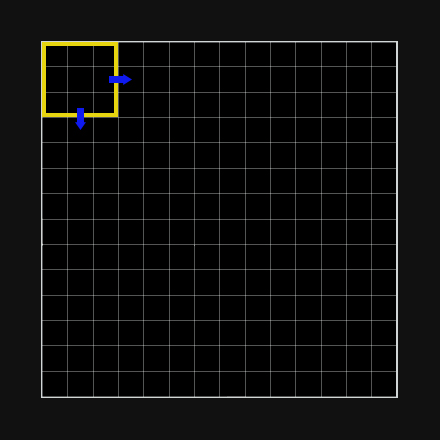

`Padding` yra atvikrštnis procesas kuris leidžia padaryti kad išvestis būtų didensė. Veikimo principas toks lyg aplinkui įvestį sukuriame papildomą erdvę kurios reikšmės dažniausiai yra lygios 0.

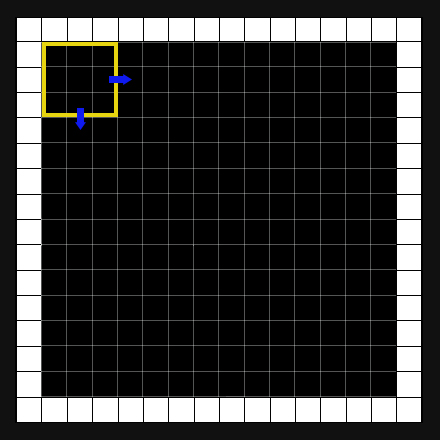

Šią operaciją galima kontroliuoti ir tiksliau `p = (1, 1, 1, 1)` nurodant kiek papildomų pikselių kaip erdvės užpildų sukurti kiekvienoje atvaizdo pusėje. Šių pikselių reikšmės dažniausiai yra 0 taip mes sukuriame tarytumei rėmelį aplinkui mūsų įvestį ir pačia įvestį taip padarome didesnę todėl po konvoliucijos išvest irgi bus didesnė.

\begin{multline*}
o = \lfloor \dfrac{i + 2p  - k}{s}\rfloor + 1 
\end{multline*}

 - `o` - išvestis
 - `i` - įvesties dydis
 - `p` - užpildo erdvės dydis
 - `k` - filtor dydis
 - `s` - žingsnio dydis

Mes šią lygtį jau naudojome apskaičiuote kokią bus išvestis atživelgiant į filtro ir žingsnio dydį. Bet praeitą kartą 2p reikšmė buvo lygi 0, šiuo atveju niekas nesikeičia tik atsiranda užpildo reikšmė.

 Yra labai gera publikacija/straipsnis kuri rekomenduoju apžvelgti [A guide to convolution arithmetic for deep
learning
](https://arxiv.org/pdf/1603.07285.pdf). Čia perpaišiau kelias illiustracijas iš šios publikacijos. Mes grįžime prie šios publikacijos kaip aptarinėsime dekonvoliucija taip vadinama transponuota konvoliucija autokodatorių temoje. 

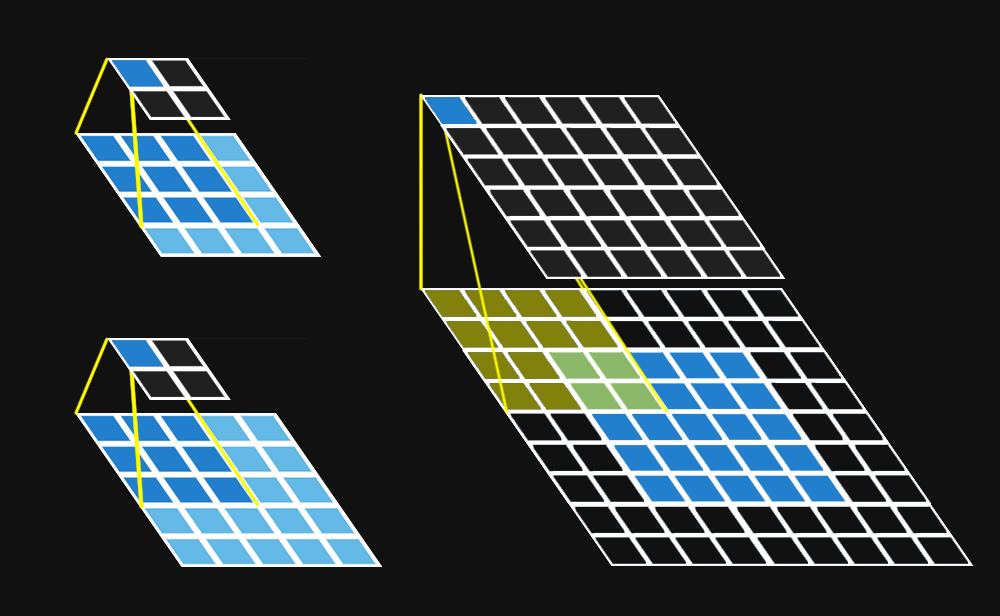

Viršuje kairėje pusėje turime `įvestį 4x4` ir žingsnį kuris lygus 1 ir jokio užpildo. Išvesties produktas 2x2 žemėlapis nes iš visų pusiu prarandame po 1 pikselių eilutę. `padding` yra 0, `stride` yra 1.

In [2]:
(4-3 + 2*0) / 1 + 1 

2.0

Sekančiame pavyzdyje įvesis yra 5x5 ir užpildas yra 2px iš visų pusių.Filtras įskaičiuoja ir užpildo erdvę (reikšmės užpilde yra lygios 0). Išvesties produktas 6x6 žemėlapis iš visų pusiu prisideda po 1 pikselių eilutę. `padding` yra 2, `stride` yra 1.

In [3]:
(5 - 4 + 2*2)/1 + 1 

6.0

Apatinis šoninis pavyzdys kuomet atliekamas žingsnis `stride` per 2 pikselius. `padding` yra 0, `stride` yra 2. Su šiai parametrais ir tokio dydžio įvestimis, išvesties produktas yra 2x2 žemėlapis.

In [5]:
(5 - 3 + 2*0)/2 + 1

2.0

### Užpildo (padding) tipai tradicinėje kompiuterinėje regoje

 - <code>**valid convoliution:**</code> jokio užpildo, savybių žemėlapis gali sumažėti;
 - <code>**same convoliution:**</code> užpildo reikšmė yra tokia kad išvesties dydis yra toks pat kaip įvesties;
 - <code>**dažniausi filtro dydžiai:**</code> 3x3, 5x5, 7x7 (kartais paskutinuose cnn sluoksniuose 1x1 kad sumažinti kanalų skaičių.

Tarkime, kad norite naudoti konvoliucinę operaciją su 1 žingsniu ir išlaikyti įvesties matmenis išvesties funkcijų žemėlapyje,
kiek užpildo `padding` reikės tai pačiai konvoliucijai (šių skaičaivimų pagalba išvengsite asimetrinių išvesčių):

\begin{multline*}
\begin{array}{rctl}
o = i + 2p - k + 1 \\
\Leftrightarrow p = (o - i + k - 1) /2 \\
\Leftrightarrow p = (k - 1 ) /2 \\
\end{array}
\end{multline*}

## Erdvinis iškritimas ir paketo normalizacija 

Edvinis iškritimas (ang. spatial droput) ir paketo normalizacija (ang. batch normalization, aka. batchnorm) nors ir skamba sudėtingai bet tai gana paprastos koncepcijos kurias galime taikyti su CNN spresti problemą kuomet gretimi pikseliai labai koreliuoja, tai gali nepadėti sumažinti priklausomybės tiek, kaip iš pradžių buvo numatyta reguliaraus iškritimo atveju (regulalr dropout). Todėl geriau yra išmesti visą savybių žemėlapį taip atsiskanat visos savybės charakteristikos. 

<code>**Dropout2D**</code> atsisakys viso savybių žemėlapių (kanalo).

In [ ]:
import torch

m      = torch.nn.Dropout2D(p=0.5)
_input = torch.randn(1, 3, 5, 5)
output = m(input)

In [ ]:
output

<code>**BatchNorm**</code> 

\begin{multline*}
y = \dfrac{x - E[x]}{\sqrt{\text{Var}[x] + \epsilon}}\ \ \times  \ \ \gamma + \beta
\end{multline*}

vidurkis ir standartinis nuokrypis apskaičiuojami <code>**NxHxW**</code> kiekvienam kanalui.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        self.cn1 = nn.Conv2D(3, 192, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2D(192)



In [ ]:
model = Model()
model.bn1.weight.size()

## Modernios CNN struktūros

Kandagi jau aptarėme LeNet-5 ir AlexNet, o DI nemažai įvyko progreso nuo 2012 kuomet buvo sukurtas AlexNet. Kadangi progresija nėra aritmetinė tai dar po šiai diena daug žmonių dirba su <code>**VGG**</code> ir <code>**ResNet**</code> nes tai geros pamatinės architektūros klasifikacijos problemos spręsti. 

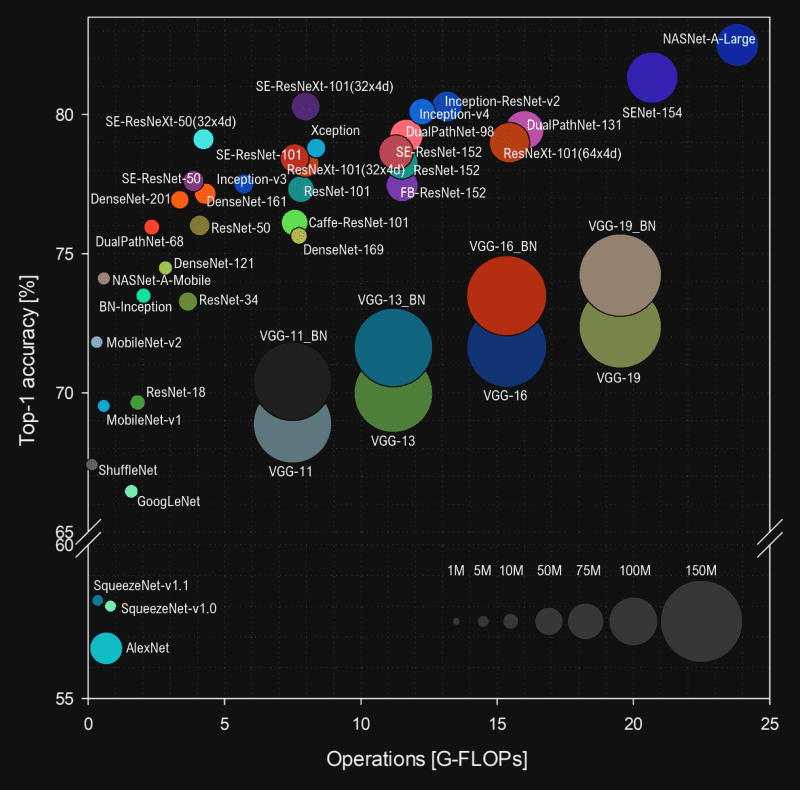

Ir šios architektūros yra ne tik apie apie parametrų kiekį (VGG-16 - 138 mln parametrų) bet ir tai pat tikslumą ir kaip grafike matote nebūtinai didelis kiekis parametrų garantuoją tikslumą. Palyginus tai  VGG 16 konvoliucinis neuroninis tinklas yra su 16 sluoksnių kurie yra gana dideli, o ResNet turi 152 sluoksnius bet šiek tiek mažiau parametrų.
ResNet / Inception su mažiau parametrų yra bet to tikslesni. ResNet atveju tai yra dėl likutinio ryšio (ang. residual connection) kas padeda išvengti nykstančių gradientų (vanishing gradients). Inception kuris turi įdomų būdą derinti įvairias arba įvairaus dydžio konvoliucijas, turintys papildomų nuostolių (kainos) skaičiavimų, pavyzdžiui, tarpinių kainos skaičiavimų tinkle, ir tokie ir panašus triukai pagerina tinklo architektūra darydami jį našesniu ir mažesniu. Ir po šiai diena vyksta toliau tyriamieji ekperimentiniai darbai su NN architektūromis. 

## VGG16 architektūra

Tai gana panašį į AlexNet architektūra išskyrus tik tai kad turime daugiau sluoksnių (16). Daugiau išsamiu detaliu rasite šioje publikacijoje [Very deep convolutional networks for large-scale image recognition](https://arxiv.org/pdf/1409.1556.pdf). Tai gana paprasta architektūra nes visos konvoliucijos yra 3x3 dydžio, žingsnis 1, užpildas visur vienodas ir toks kad įvesties dydis sutaptu su išvestimi, ir subaibės vidurkinimas `maxpolling` yra 2x2 kuris sekantį sluoksnis sumažina dvigubai. Trukūmas šios architektūros yra tai kad turi labai daug parametrų ir yra lėtas. Tas dydis kyla iš kanalų skaičiaus kurių yra labai daug visuose sluoksniuose. 

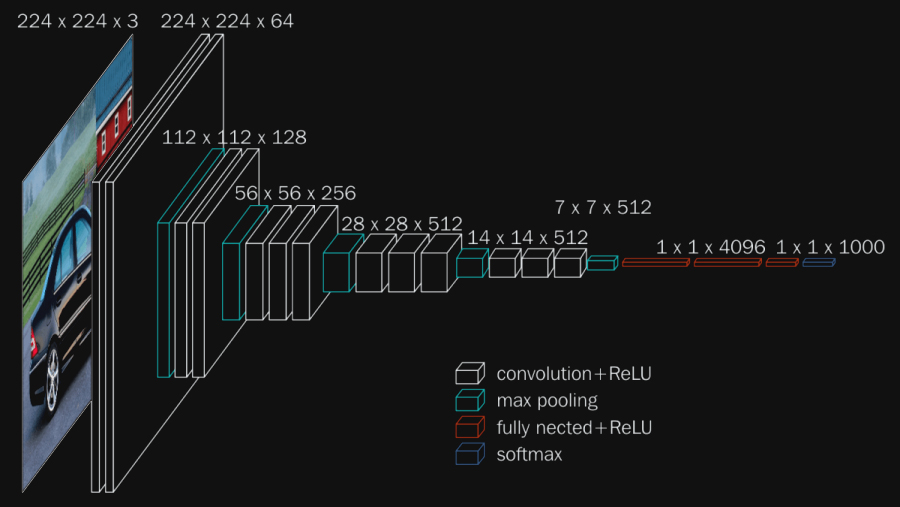

Pradeda su didelia įvestimi, ir dydžiai mažėja bet kanalų daugėja ir kiekvienas kanals išmoksta skirtingo tipo savybių informacija nes kiekvieną kanalą kurią skirtingas filtras. Ir kiekviename etape savybių žemėlapių matmenys mažėja bet jų tankis gausėja. 

[VGG16 PyTorch](./code/__II_VGG16.ipynb)

## ResNet architektūra

Ar galime pridėti daugiau sluoksnių nei turi ResNet ir tikėtis geresniu rezultatų ? Nebent rasime būda išvengti nykstančių gradientų (ang. vanishing gradients). Gradientų skančiavimo operacijoje kuomet taikome grandynės taisyklę su keliais kintamaisiais ir jeigu bent vienas iš jų yra labai maža reikšmė tai iš esmės išeliminuotos visus kitus signalus atgalinio skaičiavimo eigoje. Todėl negalime tiesiog pridėti daugiau sluoksnių ir tikėtis geresnių rezultatų, ir viena iš išeičių buvo sugalvotas `residual network`. Šio tinklo ypatybės yra `skip connections` kurios išmoksta praleisti tam tikrus sluoksnius kurie yra kenksmingi viso tinklo veikimui. Daugiau išsamios informacijos apie šį neuroninį tinklą rasite šioje publikacijoje [Deep residual learning for image recognition](https://arxiv.org/pdf/1512.03385.pdf)

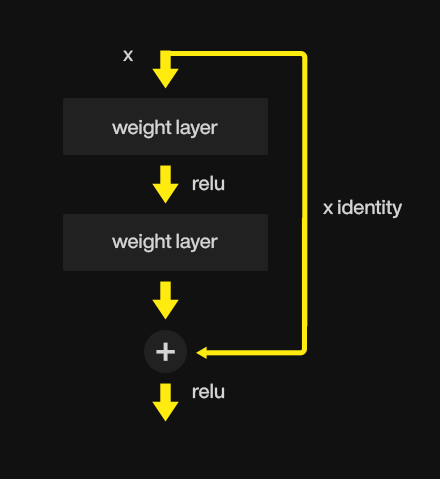

Su paprastu triuku leidžiančiu praleisti ryšius (galimybė išmokti tapatybės funkcijas ir praleisti sluoksnius (skip connections), kurie nėra naudingi), ši technika leidžia mums įgyvendinti labai gilias tinklų architektūras. Tai 2016 metais sugalvota ir vis dar populiari architektūra kuri turi keletą variacijų viena iš jų `Wide ResNet`. Bet esmė išlieka tą pati kad tinklas gali išmokti praleisti tam tikrus sluoksnius. Buvo atliktas abliacijos tyrimas kuomet pašalinama viena tinklo dalis ir stebimi rezultatai:


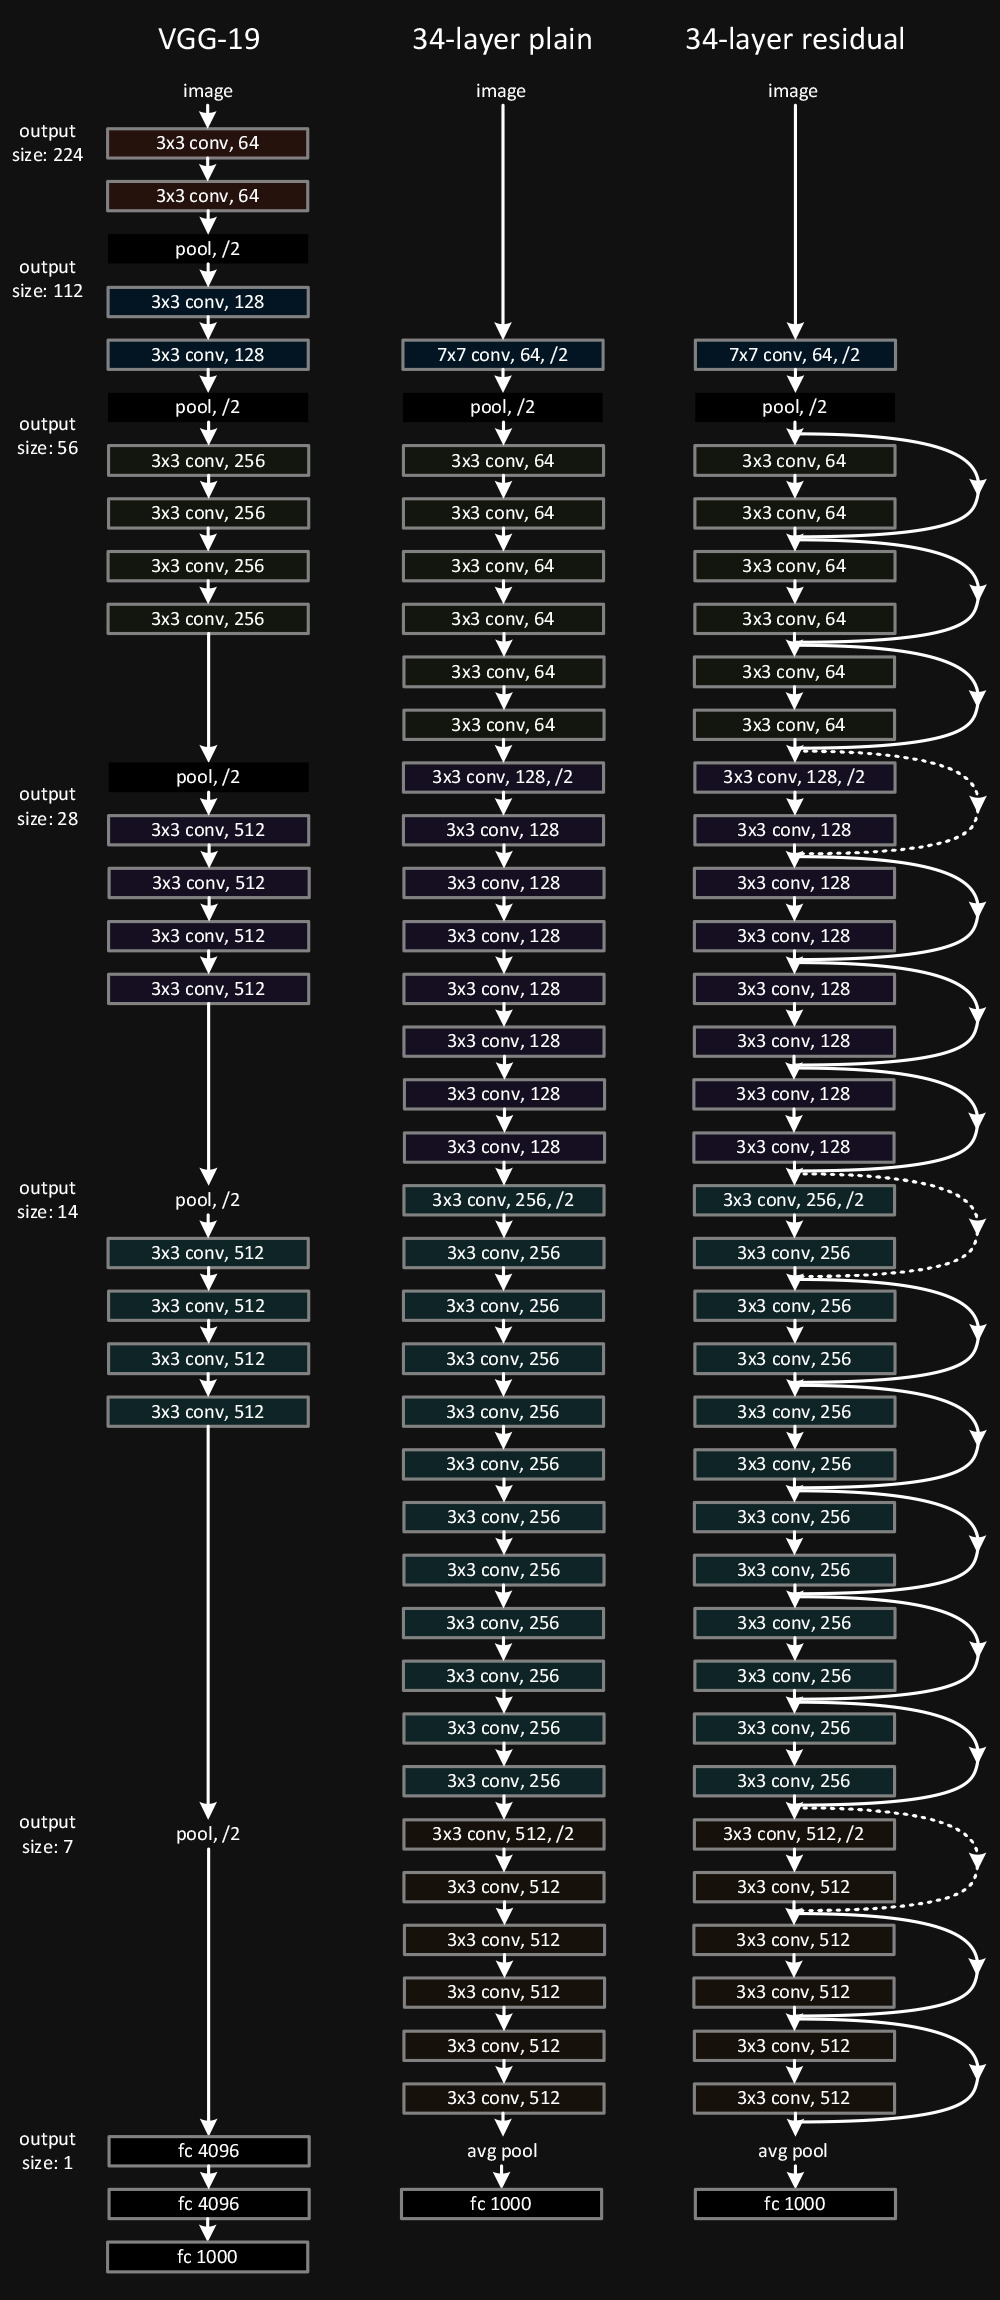

Likutinis blokas

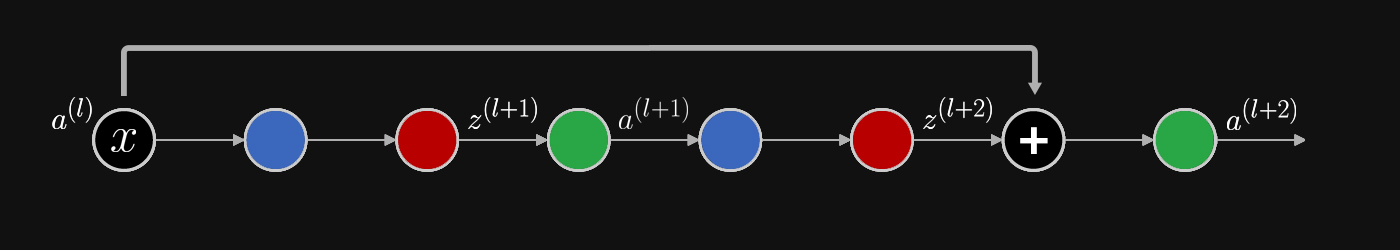

\begin{multline*}
a^{l + 2} = \sigma(z^{l+2} + a^{(l)})
\end{multline*}

Atkreipkite dėmesį kad peršokimas vyksta tik per 1.5 sluoksnio. Tai iš esmės yra kaip atrodo ryšio praleidimas.

\begin{multline*}
a^{(l+2)} = \sigma(z^{(l+2)} + a^{(l)}) = \sigma(a^{(l+1)} W^{(l+2)} + b^{(l+2)} + a^{(l)})
\end{multline*}

Jeigu yra taip kad svoriai ir poslinkis specifiniame sluoksnyje yra abu 0. Tuomet rezultatas bus toks kad neuronis tinklas išmoks tapatybę (identity mapping):

\begin{multline*}
= \sigma(a^{(l)}) = a^{(l)}
\end{multline*}

Tai yra esminė ResNet savybė kuria pats išmoksta. Išmoksta ką reikia praleisti atlikus atgalinį skaičiavimą. Todėl net jei ResNet yra didesnis tinklas tai dar nereiškia kad visi sluoksniai yra naudojami, kai kuriuos tiesiog peršoks jeigu jie neprideda arba mažina tinklo efektyvumą.<br>

<code>**Pastaba:**</code>

\begin{multline*}
a^{l + 2} = \sigma(z^{l+2} + a^{(l)})
\end{multline*}

Darome prielaidą, kad šiu terminų matmenys yra vienodi. Kad tai ir būtų reikia naudoti `same convoliution` technika: užpildo reikšmė yra tokia kad išvesties dydis yra toks pat kaip įvesties.

\begin{multline*}
z^{l+2} , a^{(l)}
\end{multline*}

Bet tai sukuria šiokia tokia problemą, nes mūsų tinklas visada turės tas pačias įvestis. Tarkime dirbame su 224x224x3 įvestimi, tai ir paskutiaime sluoksnyje jie bus 224x224x3. Todėl praktikoje yra altenratyvus budas taikydami kovoliucija ant trumpinio operacijos taip, kad įvestis, perduodama per nuorodą būtų pakeista į pagrindinio kelio išvesties matmenis.

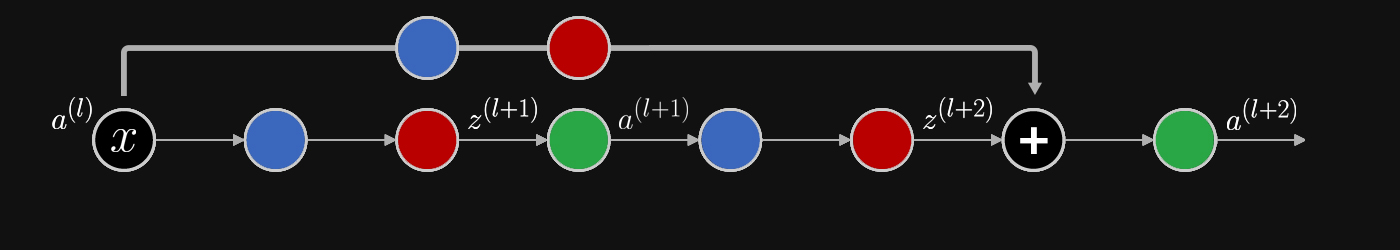

[ResNet PyTorch](./code/__II_ResNet.ipynb)<br>
[Official PyTorch ResNet models](https://pytorch.org/hub/pytorch_vision_resnet/)<br>
[PyTorch ResNet on Github](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)

## Max-Pooling pakeitimas konvoliuciniais sluoksniais

Tai supaprastina NN bet tai nebūtinai sukuria geresniu rezultatus bet yra geras minties eksperimentas. Daugiau išsamios informacijos apie šias koncepcijas rasite 2014 publikacijoje [Striving for simplicity: The all convolutional net](https://arxiv.org/pdf/1412.6806.pdf)<br>

Autorius siūlo pakeisti `maxpooling` į konvoliucinius sluoksnius, filtrus kurių žingsnis `stride` yra 2, tai pat vadinama `strided convoliution as learnable pooling`. Tradicinėje CNN struktūroje turime seka `conv` ➜ `maxpooling` ➜ `conv`. Konvoliucijos kurių žingsis `stride` yra 1 išsaugos matmenys, o maxpooling 2x2, sumažins matmenys dažniausia dvigubai. 
Tai tai pat mums padeda dėl `vietos nekintamumo`. Bet techniškai galima atsisakyti `maxpooling` ir padidinti konvoliucijų žigsnį dvigubai, stride=2 ir turėsime tą pati efektą bet yra pastebėta kad neuronis tinklą šiek tiek suletėja todėl vietoje `maxpolling` dedame tai pat dar vieną konvoliuciją kurios žingsnis yra 2 ir gausime tą pati sumažinimo efektą tai kažkuria prasme pavirsta į išmokstama suaibės vidurkinimo/telkimo operacija.<br>

In [8]:
#TODO: Global Average Pooling in Last Layer , paaiškinimai - illiustracijos.

[All convoliutional network](./code/__II_AllConvNet.ipynb)

## Konvoliucinis sluoksnis vietoje visiškai sujungtų sluoksnių

In [9]:
# optional turinys

## Perkeliamas mokymas (ang. transfer learning)

Yra keletas gerų iš anksto apmokytų kompiuterinio regėjimo modelių, kurie jums gali būti naudingi.

 - Savybių ištraukimo sluoksniai paprastai gali būti naudingi ir kitiems iš dalies panašiems uždaviniams spręsti.
 - Naudoti iš anksto apmokytą modelį (t.y apmokyta su ImageNet duomenų rinkiniu)
 - Užšaldykite svorius (neatnaujiname svorių): treniruokite tik paskutinį sluoksnį (arba kelis paskutinius sluoksnius)
 
Susijęs metodas (neužsaldomi svoriai): suderinimas (fine-tunning), - apmokykite iš anksto paruoštą tinklą su jūsų mažesniu duomenu rinkiniu.

Pritaikysime šia technika su VGG16

<code>**[torchvision.models](https://pytorch.org/vision/stable/models.html)**</code><br>
Šiame antriniame pakete yra apmokytų modelių skirtų įvairioms užduotims spręsti įskaitant: vaizdo klasifikavimą, pikselių semantinį segmentavimą, objektų aptikimą, segmentavimas, raktinio taško aptikimas, vaizdo įrašų klasifikaciją ir optinis srautas.

- AlexNet
- VGG
- ResNet
- SqueezeNet
- DenseNet
- Inception v3
- GoogleNet
- ShuffleNet v2
- MobileNet v2
- ResNeXt
- Wide ResNet
- MNASNet

<code>**Labai svarbu!**</code><br>
Jei taikysite šia techniką būkite atidus ir patikrinkite kaip autoriai kurie treniravo modelį kaip jie normalizavo duomenys. Turite naudoti tą pačia duomenų normalizacijos seką kaip ir autoriai naudojo tik su savo paties duomenų rinkiniu, pvz:

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

[Transfer learning](./code/__II_TransLearn.ipynb)

## Inception, - lygiagrečios konvoliucijos ir pagalbiniai skaičiavimai